## Objectives:

 * Understand what python objects are
 * Understand that *everything* in python is an object
 * Appreciate when/how object-oriented programming might be useful
 
 
# Tahoe correlations revisited

This notebook creates a generic Timeseries class that does useful things with timeseries data, such as calculating annual averages and matching dates between Timeseries objects.  It's basic interface looks like this:

```python

    class Timeseries():
    
        def __init()
        
        def readFromFile(fileName)
        
        def get_mutual_indices(otherTimeseriesObject)
        
        def plot()
        
        def calcualte_annual_average()
        
```

In [1]:
""" initialize the notebook """
%matplotlib inline
import netCDF4 as nc # load the netCDF library
import pylab as PP # load the plotting library
import matplotlib as mpl # import matplotlib
import datetime as dt # import the datetime libarary for date handling
import scipy.stats # get the stats library
from numpy import * # load numpy
import calendar

#Set the default font for plots
font = { 'family' : 'sans-serif', \
         'size' : '15', \
         'weight' : 'bold'}
mpl.rc('axes', labelweight = 'bold') # needed for bold axis labels in more recent version of matplotlib
mpl.rc('font', **font)

In [2]:
""" define a base class to represent a timeseries """

class TimeSeries:
    
    # the __init__ function is a special function that gets called when an instance is created
    def __init__(self,fileName = None):
        """ Initialize the timeseries from a file """
        
        if fileName is not None:
            self.fileName = fileName
            # use the function's read method to read from a file
            self.readFromFile(fileName)
        
    # define a default readFromFile() routine (this can be overriden in a derived class)
    def readFromFile(self,fileName):
        """ Read from a file using numpy's loadtxt routine.  Saves data into self.data 
            and saves dates (as datetime objects) into self.dates.  For monthly values, the day
            is set to the last day of the month."""
        
        # load the data from the CSV
        data = loadtxt(fileName,skiprows=5,delimiter=',')
        
        # save the data in the class
        self.data = data[:,1]
        
        # extract the dates
        dates = data[:,0]
        
        # convert the dates to datetime objects
        dtobjs = []
        for i in range(self.data.shape[0]):
            yyyymm = dates[i]

            # convert the date to a string
            string_value = str(int(yyyymm))

            # extract the year
            year = int(string_value[:4])

            # extract the month
            month = int(string_value[4:6])

            # get the last day of this month
            # note the use of '_' in the following line.  This is a variable that can be used to throw away unwanted
            # return values.
            _,day = calendar.monthrange(year,month)

            # convert this to a datetime object
            dtobj = dt.datetime(year,month,day)

             # add it to the list
            dtobjs.append(dtobj)
            
        # save the dates
        self.dates = dtobjs
        
    def get_mutual_indices(self,otherTimeseries):
        """Given another Timeseries object, return indicies for this Timeseries and the other timeseries
           only for the times that match in both.
           
           input:
           ------
           otherTimeseries : a Timeseries instanance
           
           output:
           -------
           
           indices_1, indices_2 :  indices for self and indices for otherTimeseries such that
                                   self.dates[indices_1] == otherTimeseries[indices_2]
        """
        
        # create sets out of the dates
        date1_set = set(self.dates)
        date2_set = set(otherTimeseries.dates)
        
        # get the intersecting dates (and sort to preserve order)
        intersecting_set = sorted(date1_set.intersection(date2_set))
        
        # get the indices of these dates in the first set
        inds_1 = [ self.dates.index(d) for d in intersecting_set ]
        inds_2 = [ otherTimeseries.dates.index(d) for d in intersecting_set ]
        
        return inds_1, inds_2
        
        

    def plot(self,do_show = True):
        """Plots the timeseries.  do_show (boolean) flags whether to call show()."""
        fig,ax = PP.subplots(figsize=(10,8))
        
        ax.plot(self.dates,self.data,'-')
        
        if do_show:
            PP.show()
            
    def calculate_annual_average(self):
        """Returns a Timeseries object where the data values represent annual averages"""
        
        # get the start and end dates
        start_year = self.dates[0].year
        end_year = self.dates[-1].year
        
        # create a years array representing the year of each datum
        years = array([ d.year for d in self.dates])
        
        # loop over years
        new_dates = []
        new_data = []
        for year in range(start_year,end_year + 1):
            # get indices matching this year
            iyear = where(years == year)

            # check if we have a full year
            if len(iyear[0]) == 12:
                # calculate the average over the current year
                new_datum = average(self.data[iyear])
            
                # set the new date
                new_date = dt.datetime(year,6,30)

                # append them to the list
                new_dates.append(new_date)
                new_data.append(new_datum)
            
        # create a new datetime object
        newObj = TimeSeries()
        newObj.dates = new_dates
        newObj.data = array(new_data)
        
        # return the new object
        return newObj

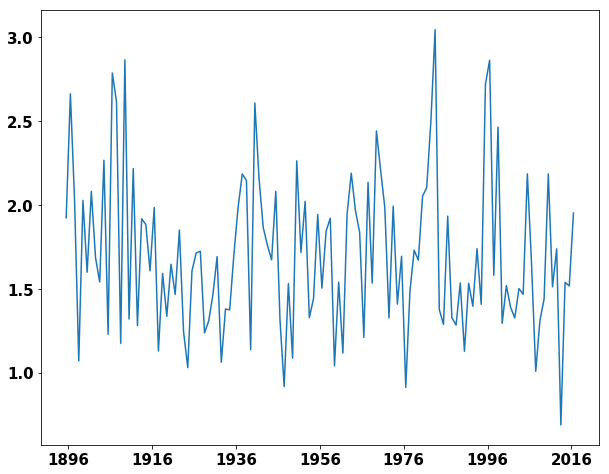

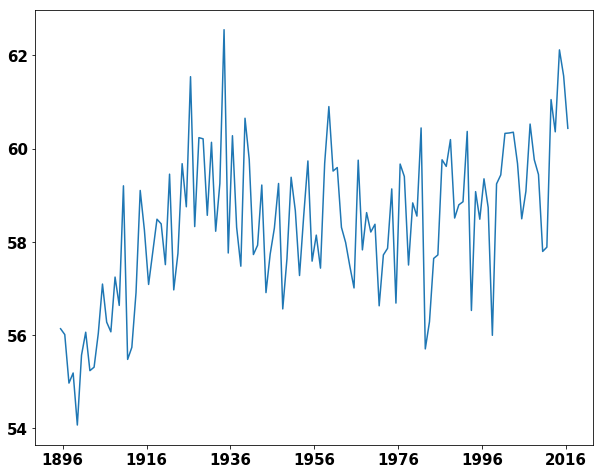

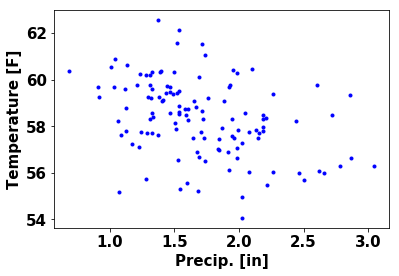

In [3]:
# load the precip data
precip_timeseries = TimeSeries('../data/precip_division3_1895-2017.csv')

tmax_timeseries = TimeSeries('../data/tmax_division3_1895-2017.csv')

# calculate annual averages
precip_avg = precip_timeseries.calculate_annual_average()
tmax_avg = tmax_timeseries.calculate_annual_average()

# plot them
precip_avg.plot()
tmax_avg.plot()

# get matching indices
pinds, tinds = precip_avg.get_mutual_indices(tmax_avg)

PP.plot(precip_avg.data[pinds], tmax_avg.data[tinds],'b.')
PP.xlabel('Precip. [in]')
PP.ylabel('Temperature [F]')
PP.show()

Now that we have a basic timeseries routine, let's create a derived one to read in Tahoe data.

In [4]:
class TahoeTimeSeries(TimeSeries):
    """A timeseries derived from USGS Tahoe Depth data"""
    
    # redefine the readFromFile routine
    def readFromFile(self,fileName):
        """ Read from a file using numpy's loadtxt routine.  Saves data into self.data 
            and saves dates (as datetime objects) into self.dates.  For monthly values, the day
            is set to the last day of the month."""
        
        # define a helper function to parse a line in the file
        def parse_file_line(line):
            """ Given a line from the USGS Tahoe gage datum file, parse the date gage datum.

                :param line: a line from the Tahoe gade datum file

                :rtype: (datetime,gageheight)

            There are two types of gageheight data used; this function returns whichever is available.
            """

            # The file is tab-separated and the header of the file states that the columns are ordered as follows:
            #
            #    agency_cd	site_no	datetime	02_00065_00011	02_00065_00011_cd	02_00065_32400	02_00065_32400_cd 5s	15s	20d	14n	10s	14n	10s
            #
            # The '02_00065_00011' and '02_00065_32400' fields are the gage data, and the fields ending in _cd are the quality
            # control flags.  The date is in the 'datetime' field.
            # 
            # So we want to return column 2 and column 3 or 5.

            if line[0] != "#":
                # parse the line into columns
                columns = line.split()

                # get either column 3 or 5
                try:
                    gage_datum = float(columns[3])
                except:
                    try:
                        gage_datum = float(columns[5])
                    except:
                        gage_datum = None

                # parse the date only if there was valid data here
                if gage_datum is not None:
                    # extract the year, month, and day from column 2
                    year,month,day = columns[2].split('-')
                    # convert it to a datetime object
                    dtobj = dt.datetime(int(year),int(month),int(day))
                else:
                    # otherwise set the date to None
                    dtobj = None
            else:
                dtobj = None
                gage_datum = None

            return (dtobj,gage_datum)


        # open the file and read the lines
        with open(fileName,'r') as fin:
            file_lines = fin.readlines()

        gage_dates_and_data = []
        for i in range(32,len(file_lines)):
            if parse_file_line(file_lines[i])[0] is not None:
                gage_dates_and_data.append(parse_file_line(file_lines[i]))



        # extract the data into arrays, only saving the data for the last day of the month
        # loop over all the parsed data
        gage_dates = []
        gage_data = []
        for dtobj,gage_datum in gage_dates_and_data:
            # check if the date is the last day of the month
            # get the last day of this month
            # note the use of '_' in the following line.  This is a variable that can be used to throw away unwanted
            # return values.
            _,lastday = calendar.monthrange(dtobj.year,dtobj.month)

            if dtobj.day == lastday:
                # save the current date
                gage_dates.append(dtobj)
                # save the gage height data
                gage_data.append(gage_datum)

        # convert the lists to numpy arrays
        gage_dates = gage_dates
        gage_data = array(gage_data)

        # save them into the object
        self.dates = gage_dates
        self.data = gage_data

           

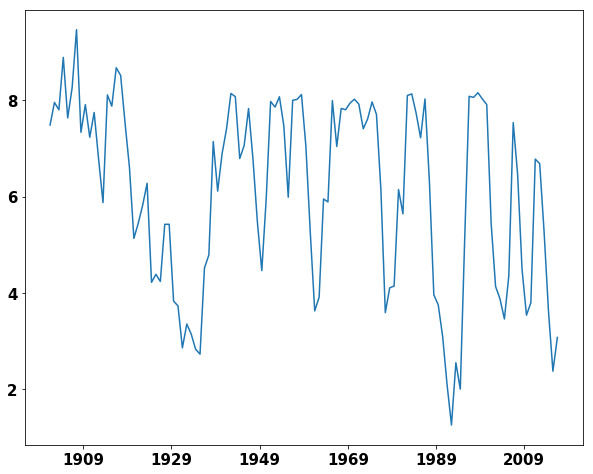

In [5]:
tahoe_depth_timeseries = TahoeTimeSeries("../data/tahoe_gage_height_1990_to_2017.txt")

tahoe_depth_avg = tahoe_depth_timeseries.calculate_annual_average()
tahoe_depth_avg.plot()

Now, if everything worked as expected, then pairing the gage data and temperature data should be quite simple:

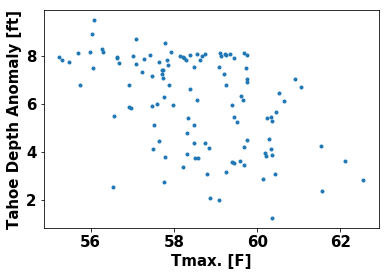

In [6]:
tinds, dinds = tmax_avg.get_mutual_indices(tahoe_depth_avg)

PP.plot(tmax_avg.data[tinds],tahoe_depth_avg.data[dinds],'.')
PP.xlabel('Tmax. [F]')
PP.ylabel('Tahoe Depth Anomaly [ft]')
PP.show()

There we go!  Now we see a correlation between tmax and Tahoe depth, which is what we originally hypothesized.  Note how easy it was to look at correlations between the annual averages once we had coded up a routine to do that in the original class.  The only unique thing about the Tahoe data was the reader, which was easy to design based on what we did earlier in the class.